# Linear Buckling of a Metal Panel
TODO : add either relu kernel zero at boundary
and/or add kernels of different length scales.
Also could try Matern kernel or other kernels that can mix different length scales.
For buckling could try some type of sine kernel?

In [36]:
# panel linear buckling
# buckling inputs
# ----------------

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
R = 1; L = 3
# (a, b) = (1,1)

# choose kernel hyperparameters
# Lx, Ly = (0.5, 0.4)
Lx, Ly = (0.5, 1.0)
eta = 1e-7
afrac = 0.5
# eta = 1e-5

# num_domain, num_bndry, num_test = (10, 5, 5)
# num_domain, num_bndry, num_test = (500, 200, 50)
# num_domain, num_bndry, num_test = (3000, 600, 50)
# num_domain, num_bndry, num_test = (1000, 500, 50)
num_domain, num_bndry, num_test = (2000, 700, 50)

In [ ]:
# buckling inputs
import numpy as np
Nxx = 1e3

np.random.seed(123456)

# predict the buckling load factor (BLF)
pi = 3.14159
# closed-form solution of the cylinder
# not sure if this is right or not
Nxxcr = E * thick**2 / np.sqrt(3 * (1 - nu**2)) / R
pred_load_factor = Nxxcr / Nxx

type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


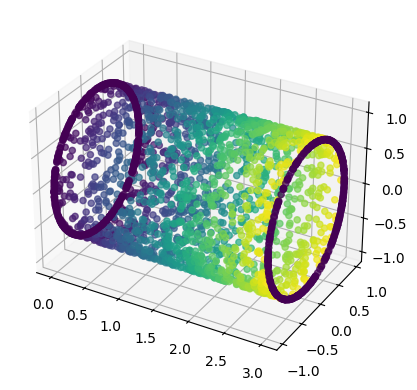

In [38]:
# compute the linear static analysis inputs and mesh domain of collocation pts
# ----------------------------------------------------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

num_interior = num_domain
DTYPE = tf.float32

lb = tf.constant([0, 0], dtype=DTYPE)
ub = tf.constant([L, 2*np.pi], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    th_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, th_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x_train = x_train.numpy()
x = x_train[:,0:1]
r = R * np.ones((num_interior,1))
th = x_train[:,1:2]
y = r * np.cos(th)
z = r * np.sin(th)

# x2 = x_test[:,0:1]
# y2 = x_test[:,1:2]

# generate boundary domain points
assert num_bndry % 2 == 0
lb1 = tf.constant([0, 0], dtype=DTYPE)
ub1 = tf.constant([0, 2*np.pi], dtype=DTYPE)
X_b1 = gen_collocation_points(int(num_bndry/2), lb1, ub1)

lb2 = tf.constant([L, 0], dtype=DTYPE)
ub2 = tf.constant([L, 2*np.pi], dtype=DTYPE)
X_b2 = gen_collocation_points(int(num_bndry/2), lb2, ub2)

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)
x_b = x_bndry[:,0:1]
# r_b = x_bndry[:,1:2]
r_b = R * np.ones((num_bndry,1))
th_b = x_bndry[:,1:2]
y_b = r_b * np.cos(th_b)
z_b = r_b * np.sin(th_b)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = x / L
sizes = 20 * np.ones((num_interior,))
scatter = ax.scatter(x_b, y_b, z_b, c=0.0 * r_b/r_b, s=20 * r_b/r_b, cmap='viridis', alpha=0.7)
scatter = ax.scatter(x, y, z, c=colors, s=sizes, cmap='viridis', alpha=0.7)

plt.gca().set_aspect('equal')
plt.show()

In [39]:
# find the x_train point nearest the center and sort it so that one is first
# or change first point to the midpoint
x_train[0,0] = L*afrac # near middle but not exactly
x_train[0,1] = np.pi / 2.0

In [40]:
# define vectorized versions of the kernel functions
# like 1000x faster at assembling covariance functions

from _kernels._rbf_kernels import *

L_tf = tf.constant(np.array([Lx, Ly]), dtype=DTYPE)
def kernel2d_tf(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf
    # output is N x M matrix of kernel matrix
    return tf.exp(-0.5 * tf.reduce_sum(tf.pow(xbar, 2.0), axis=-1))

def dx2_kernel(x, xp):
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * (d2_fact(x1bar, Lx))

def dx4_kernel(x, xp):
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * (d4_fact(x1bar, Lx))

def dx6_kernel(x, xp):
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * (d6_fact(x1bar, Lx))

def dx8_kernel(x, xp):
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * (d8_fact(x1bar, Lx))


def dx10_kernel(x, xp):
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * (d10_fact(x1bar, Lx))

def dx12_kernel(x, xp):
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * (d12_fact(x1bar, Lx))

def nabla4_dx2_kernel(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * (d6_fact(x1bar,Lx) + 2.0/R**2 * d4_fact(x1bar, Lx) * d2_fact(x2bar, Ly) + 1.0/R**4 * d2_fact(x1bar, Lx) * d4_fact(x2bar, Ly))

def nabla4_dx4_kernel(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * (d8_fact(x1bar,Lx) + 2.0/R**2 * d6_fact(x1bar, Lx) * d2_fact(x2bar, Ly) + 1.0/R**4 * d4_fact(x1bar, Lx) * d4_fact(x2bar, Ly))

def nabla4_dx6_kernel(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * (d10_fact(x1bar,Lx) + 2.0/R**2 * d8_fact(x1bar, Lx) * d2_fact(x2bar, Ly) + 1.0/R**4 * d6_fact(x1bar, Lx) * d4_fact(x2bar, Ly))


def nabla4_dx8_kernel(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * (d12_fact(x1bar,Lx) + 2.0/R**2 * d10_fact(x1bar, Lx) * d2_fact(x2bar, Ly) + 1.0/R**4 * d8_fact(x1bar, Lx) * d4_fact(x2bar, Ly))

def nabla8_kernel(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * \
        (d8_fact(x1bar,Lx) + \
         4.0/R**2 * d6_fact(x1bar, Lx) * d2_fact(x2bar, Ly) +\
         6.0/R**4 * d4_fact(x1bar, Lx) * d4_fact(x2bar, Ly) +\
         4.0/R**6 * d2_fact(x1bar, Lx) * d6_fact(x2bar, Ly) +\
         1.0/R**8 * d8_fact(x2bar, Ly))

def nabla8_dx2_kernel(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * \
        (           d10_fact(x1bar,Lx) + \
         4.0/R**2 * d8_fact(x1bar, Lx) * d2_fact(x2bar, Ly) +\
         6.0/R**4 * d6_fact(x1bar, Lx) * d4_fact(x2bar, Ly) +\
         4.0/R**6 * d4_fact(x1bar, Lx) * d6_fact(x2bar, Ly) +\
         1.0/R**8 * d2_fact(x1bar, Lx) * d8_fact(x2bar, Ly))

def nabla8_dx4_kernel(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * \
        (           d12_fact(x1bar,Lx) + \
         4.0/R**2 * d10_fact(x1bar, Lx) * d2_fact(x2bar, Ly) +\
         6.0/R**4 * d8_fact(x1bar, Lx) * d4_fact(x2bar, Ly) +\
         4.0/R**6 * d6_fact(x1bar, Lx) * d6_fact(x2bar, Ly) +\
         1.0/R**8 * d4_fact(x1bar, Lx) * d8_fact(x2bar, Ly))

def nabla8_dx6_kernel(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * \
        (           d14_fact(x1bar,Lx) + \
         4.0/R**2 * d12_fact(x1bar, Lx) * d2_fact(x2bar, Ly) +\
         6.0/R**4 * d10_fact(x1bar, Lx) * d4_fact(x2bar, Ly) +\
         4.0/R**6 * d8_fact(x1bar, Lx) * d6_fact(x2bar, Ly) +\
         1.0/R**8 * d6_fact(x1bar, Lx) * d8_fact(x2bar, Ly))

def nabla12_dx2_kernel(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * \
        (           d14_fact(x1bar,Lx) + \
         6.0/R**2 * d12_fact(x1bar, Lx) *  d2_fact(x2bar,Ly) +\
         15.0/R**4 * d10_fact(x1bar, Lx) *  d4_fact(x2bar, Ly) +\
         21.0/R**6 * d8_fact(x1bar, Lx) *  d6_fact(x2bar, Ly) +\
         15.0/R**8 * d6_fact(x1bar, Lx) *  d8_fact(x2bar, Ly) +\
         15.0/R**10 * d4_fact(x1bar, Lx) * d10_fact(x2bar, Ly) +\
         1.0/R**12 * d2_fact(x1bar, Lx) *  d12_fact(x2bar, Ly))

def nabla16_kernel(x, xp):
    """composite kernel definition"""
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]
    K = kernel2d_tf(x,xp)
    return K * \
        (           d16_fact(x1bar,Lx) + \
         8.0/R**2 * d14_fact(x1bar, Lx) *  d2_fact(x2bar,Ly) +\
         28.0/R**4 * d12_fact(x1bar, Lx) *  d4_fact(x2bar, Ly) +\
         56.0/R**6 * d10_fact(x1bar, Lx) *  d6_fact(x2bar, Ly) +\
         70.0/R**8 * d8_fact(x1bar, Lx) *  d8_fact(x2bar, Ly) +\
         56.0/R**10 * d6_fact(x1bar, Lx) * d10_fact(x2bar, Ly) +\
         28.0/R**12 * d4_fact(x1bar, Lx) *  d12_fact(x2bar, Ly) +\
         8.0/R**14 * d2_fact(x1bar, Lx) * d14_fact(x2bar, Ly) +\
         1.0/R**16 * d16_fact(x2bar, Ly))

num_interior=2000 num_all=2700


2024-12-07 00:16:02.302640: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 466560000 exceeds 10% of free system memory.
2024-12-07 00:16:02.392338: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 466560000 exceeds 10% of free system memory.
2024-12-07 00:16:02.688490: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 466560000 exceeds 10% of free system memory.


done with eigenvalues solve


2024-12-07 00:16:03.113741: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 466560000 exceeds 10% of free system memory.


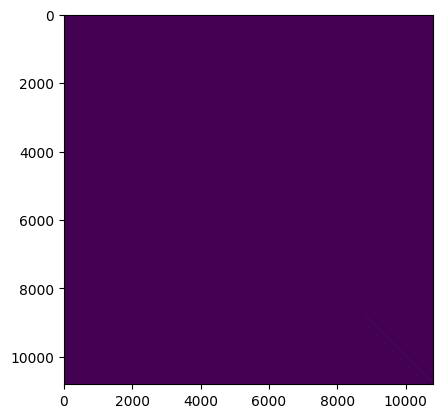

In [41]:
# compute the block matrix Sigma = [cov(w_int, w_int), cov(w_int, w_bndry), cov(w_int, nabla^4 w_int),
#                                   cov(w_bndry, w_int), cov(w_bndry, w_bndry), cov(w_bndry, nabla^4 w_bndry),
#                                   cov(nabla^4 w_int, w_int), cov(nabla^4 w_int, w_bndry), cov(nabla^4 w_int, nabla^4 w_int) ]
# not a function of theta..
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

n_block = 3 * num_interior + 4 * num_bndry
x_all = tf.concat([x_train, x_bndry], axis=0)
num_all = num_interior + num_bndry

# components of the multivariate GP

# 11 - interior+bndry self-covariance
x_all_L = tf.expand_dims(x_all, axis=1)
x_all_R = tf.expand_dims(x_all, axis=0)
K11 = tf.constant(kernel2d_tf(x_all_L, x_all_R), dtype=DTYPE)

x_interior_L = tf.expand_dims(x_train, axis=1)
x_interior_R = tf.expand_dims(x_train, axis=0)
x_bndry_L = tf.expand_dims(x_bndry, axis=1)
x_bndry_R = tf.expand_dims(x_bndry, axis=0)

K12 = tf.constant(dx2_kernel(x_all_L, x_bndry_R), dtype=DTYPE)
K13 = tf.constant(dx4_kernel(x_all_L, x_all_R), dtype=DTYPE)
K14 = tf.constant(dx6_kernel(x_all_L, x_bndry_R), dtype=DTYPE)
K15 = tf.constant(nabla4_dx2_kernel(x_all_L, x_interior_R), dtype=DTYPE)
K16 = tf.constant(nabla8_kernel(x_all_L, x_interior_R), dtype=DTYPE)

K22 = tf.constant(dx4_kernel(x_bndry_L, x_bndry_R), dtype=DTYPE)
K23 = tf.constant(dx6_kernel(x_bndry_L, x_all_R), dtype=DTYPE)
K24 = tf.constant(dx8_kernel(x_bndry_L, x_bndry_R), dtype=DTYPE)
K25 = tf.constant(nabla4_dx4_kernel(x_bndry_L, x_interior_R), dtype=DTYPE)
K26 = tf.constant(nabla8_dx2_kernel(x_bndry_L, x_interior_R), dtype=DTYPE)

K33 = tf.constant(dx8_kernel(x_all_L, x_all_R), dtype=DTYPE)
K34 = tf.constant(dx10_kernel(x_all_L, x_bndry_R), dtype=DTYPE)
K35 = tf.constant(nabla4_dx6_kernel(x_all_L, x_interior_R), dtype=DTYPE)
K36 = tf.constant(nabla8_dx4_kernel(x_all_L, x_interior_R), dtype=DTYPE)

K44 = tf.constant(dx12_kernel(x_bndry_L, x_bndry_R), dtype=DTYPE)
K45 = tf.constant(nabla4_dx8_kernel(x_bndry_L, x_interior_R), dtype=DTYPE)
K46 = tf.constant(nabla8_dx6_kernel(x_bndry_L, x_interior_R), dtype=DTYPE)

K55 = tf.constant(nabla8_dx4_kernel(x_interior_L, x_interior_R), dtype=DTYPE)
K56 = tf.constant(nabla12_dx2_kernel(x_interior_L, x_interior_R), dtype=DTYPE)

K66 = tf.constant(nabla16_kernel(x_interior_L, x_interior_R), dtype=DTYPE)

print(f"{num_interior=} {num_all=}")
# print(f"{K11.shape=} {K12.shape=} {K22.shape=}")
# print(f"{K13.shape=} {K23.shape=} {K33.shape=}")

# assemble full covariance matrix
_row1 = tf.constant(tf.concat([K11, K12, K13, K14, K15, K16], axis=1))
_row2 = tf.constant(tf.concat([tf.transpose(K12), K22, K23, K24, K25, K26], axis=1))
_row3 = tf.constant(tf.concat([tf.transpose(K13), tf.transpose(K23), K33, K34, K35, K36], axis=1))
_row4 = tf.constant(tf.concat([tf.transpose(K14), tf.transpose(K24), tf.transpose(K34), K44, K45, K46], axis=1))
_row5 = tf.constant(tf.concat([tf.transpose(K15), tf.transpose(K25), tf.transpose(K35), tf.transpose(K45), K55, K56], axis=1))
_row6 = tf.constant(tf.concat([tf.transpose(K16), tf.transpose(K26), tf.transpose(K36), tf.transpose(K46), tf.transpose(K56), K66], axis=1))
Kblock_prereg = tf.concat([_row1, _row2, _row3, _row4, _row5, _row6], axis=0)

# from paper on this by Chen, need to use adaptive nugget term with trace ratio
tr11 = tf.linalg.trace(K11)
tr22 = tf.linalg.trace(K22)
tr33 = tf.linalg.trace(K33)
tr44 = tf.linalg.trace(K44)
tr55 = tf.linalg.trace(K55)
tr66 = tf.linalg.trace(K66)
diagonal = tf.concat([tf.ones((num_all,)), tr22 / tr11 * tf.ones((num_bndry,)), \
                      tr33 / tr11 * tf.ones((num_all,)), \
                      tr44 / tr11 * tf.ones((num_bndry,)), \
                      tr55 / tr11 * tf.ones((num_interior,)), \
                      tr66 / tr11 * tf.ones((num_interior,))], axis=0)
regularization = eta * tf.linalg.diag(diagonal)
plt.imshow(regularization)

print("done with eigenvalues solve")

Kblock = tf.constant(Kblock_prereg + regularization, dtype=DTYPE)

# # show the matrix image to see if positive definite roughly
# plt.imshow(Kblock)
# plt.colorbar()

In [42]:
Kblock = Kblock.numpy()

theta = np.zeros((3*num_interior,1))
theta[-1,0] = pred_load_factor # initial gues for lam
ntheta = 3 * num_interior

w0 = np.ones((1,1)) * 1.0e-2 # at 1st point (arbitrary)

eye_int = np.eye(num_interior)
eye_bndry = np.eye(num_bndry)
zero_cross = np.zeros((num_interior, num_bndry))
zero_int = np.zeros((num_interior,1))
zero_int_mat = np.zeros((num_interior, num_interior))
zero_bndry = np.zeros((num_bndry,1))
zscale = 1e3
# lam = pred_load_factor # proposed eigenvalue, could tune this as part of theta later also

In [48]:
# newton's algorithm
# ------------------
# non-zero init
# theta[2] = 1.0


# c : regularization constant for term c * (|th|-1)^2
# c = 1e0

for inewton in range(5):
    # theta1 - w(Omega), theta2 - dx4 w(Omega)
    theta1 = theta[:num_interior-1,:]; theta2 = theta[num_interior-1:2*num_interior-1,:]; theta3 = theta[2*num_interior-1:-1,:]; lam = theta[-1,0]

    # matrix is dimensions num_interior x num_block
    dzdth = np.concatenate([
        #               w(int)   w(ext)      dx2(ext)      dx4(int)    dx4(ext)    dx6(ext)    nabla^4 dx2(int) nabla^8(int)
        np.concatenate([eye_int, zero_cross, zero_cross, zero_int_mat, zero_cross, zero_cross, zero_int_mat, zero_int_mat], axis=1), # theta1 - w int
        np.concatenate([zero_int_mat, zero_cross, zero_cross, eye_int, zero_cross, zero_cross, zero_int_mat, -E/D/R**2 * eye_int], axis=1), # theta2 - dx4 int
        np.concatenate([zero_int_mat, zero_cross, zero_cross, zero_int_mat, zero_cross, zero_cross, eye_int, -lam*Nxx/D*eye_int], axis=1), # theta3 - nabla^4 dx2 int
        np.concatenate([np.zeros((1, 3 * num_interior + 4 * num_bndry)), -Nxx/D * theta3.T], axis=1) # lam sensitivity row
    ], axis=0) * zscale

    # modify the matrix to have 1 fewer row (first row eliminated and 1st column is zero for constrained theta value)
    dzdth = dzdth[1:,:]
    dzdth[:,0] = 0.0

    # print(f"{Kblock.shape=}")
    # print(f"{dzdth.shape=}")
    
    # get actual value of z as in nMAP = z^T * Cov^-1 * z
    z = np.concatenate([
        w0, theta1, zero_bndry, zero_bndry, theta2, zero_bndry, zero_bndry, theta3, -E/D/R**2 * theta2 - lam * Nxx / D * theta3
    ], axis=0) * zscale
    # print(f"{z=}")

    # H * dth = -grad is newton update
    temp = np.linalg.solve(Kblock, dzdth.T)
    H = 2 * dzdth @ temp

    # regularization for H matrix
    H += 1e-7 * np.eye(ntheta)

    temp2 = np.linalg.solve(Kblock, z)
    grad = 2 * dzdth @ temp2

    # regularization corrections
    # th_norm = np.linalg.norm(theta) + 1e-16
    # c2 = 2.0 * c * (1 - 1.0 / th_norm)
    # H += c2 * np.eye(2*num_interior)
    # grad += c2 * theta

    # newton update
    dtheta = -np.linalg.solve(H, grad)
    # print(f"{dtheta.shape=} {theta.shape=}")
    # theta.assign(theta + dtheta)
    alpha = 1.0
    theta = theta + alpha * dtheta

    # new objective cost
    # new objective cost
    newz = np.concatenate([
        w0, theta1, zero_bndry, zero_bndry, theta2, zero_bndry, zero_bndry, theta3, -E/D/R**2 * theta2 - lam * Nxx / D * theta3
    ], axis=0) * zscale
    temp3 = np.linalg.solve(Kblock, newz)
    loss = (newz.T @ temp3)[0,0]
    print(f"{inewton=} {loss=} {lam=}")

inewton=0 loss=-47066711.36746604 lam=2202.324956210228
inewton=1 loss=570682452.2473845 lam=-295.8711932540482
inewton=2 loss=5392776473.6966095 lam=2528.087243789807
inewton=3 loss=5576716673.16522 lam=653.2213895577065
inewton=4 loss=3663356513.2187824 lam=-513.3535557195808


In [49]:
# predict the values at a grid of points (a mesh) so we can view predicted contour of the solution
# using the mean interpolated from trained values
import numpy as np

w_full = newz / zscale

n = 100
ngrid = n * n
_xgrid = np.linspace(0.0, L, n)
_thgrid = np.linspace(0.0, 2 * np.pi, n)
Xgrid, THgrid = np.meshgrid(_xgrid, _thgrid)
print(f"{Xgrid.shape=}")
xgrid = np.reshape(Xgrid, newshape=(ngrid,1))
thgrid = np.reshape(THgrid, newshape=(ngrid,1))
x_grid = np.concatenate([xgrid, thgrid], axis=1)

# old non-vectorized way
# K_train = np.array([[kernel2d(x_all[i,:], x_all[j,:]) for j in range(num_all)] for i in range(num_all)])
# K_cross = np.array([[kernel2d(x_grid[i,:], x_all[j,:]) for j in range(num_all)] for i in range(ngrid)])

# vectorized way like 100x faster
K_train = kernel2d_tf(x_all_L, x_all_R)
x_grid_L = tf.expand_dims(tf.constant(x_grid, dtype=DTYPE), axis=1)
K_cross = kernel2d_tf(x_grid_L, x_all_R)

max_eigval = np.max(np.linalg.eigvalsh(K_train))
W_grid = tf.linalg.matmul(K_cross, np.linalg.solve(K_train + 1e-5 * max_eigval * np.eye(num_all), w_full[:num_all,:]))
W = np.reshape(W_grid, newshape=(n, n))

# now also compute X, Y, Z coordinates in the grid not just polar
Rgrid = R * np.ones((n, n))
Ygrid = Rgrid * np.cos(THgrid)
Zgrid = Rgrid * np.sin(THgrid)

Xgrid.shape=(100, 100)


In [56]:
# deformed state ?
scale_factor = 1.0 / np.max(np.abs(W))
Xgrid_def = Xgrid
Ygrid_def = (Rgrid + W * scale_factor) * np.cos(THgrid)
Zgrid_def = (Rgrid + W * scale_factor) * np.sin(THgrid)

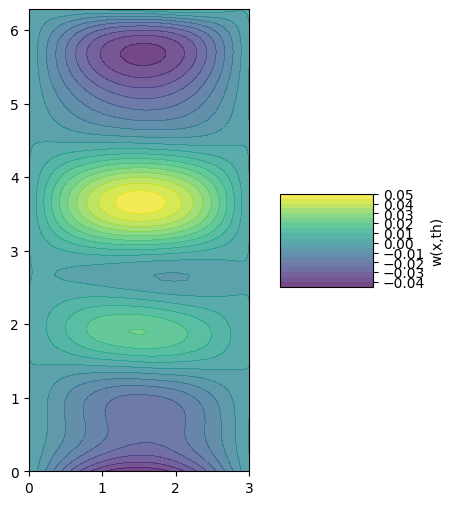

In [57]:
import matplotlib.pyplot as plt
# now plot the predicted solution contour
plt.figure(figsize=(8, 6))
colors = plt.contourf(Xgrid, THgrid, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
plt.gca().set_aspect('equal')
plt.colorbar(colors, label="w(x,th)", shrink=0.5, aspect=1)  # Colorbar for reference

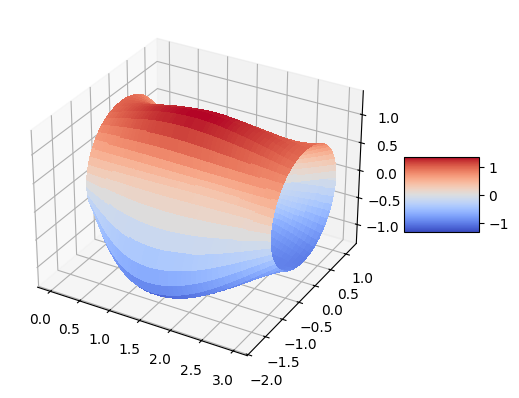

In [58]:
import matplotlib.pyplot as plt
from matplotlib import cm
# now plot the predicted solution surface in 3d
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Xgrid_def, Ygrid_def, Zgrid_def, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=1)
ax.set_aspect('equalxy')
plt.show()